少数しか reference がないときの測光誤差をどう考えたらいいか考えてみた．

モックデータとしてなんとなく星のナンバーカウントのようなものを作る．

In [1]:
import numpy
import pylab
sample = numpy.random.power(a=10,size=10000)*20
pylab.hist(sample)
pylab.xlabel("Magnitude")
pylab.ylabel("dN/dm")
pylab.semilogy()
pylab.show()

<Figure size 640x480 with 1 Axes>

その中から Nayuta の観測と同じように数個 (nchoice) の星を選んで，適当にそれっぽく見えるエラーをつける．縦も横もそれで振る．ここではカタログ等級のほうが5倍悪いことにしている．

(20.49110390549074, 15.256858471846686)

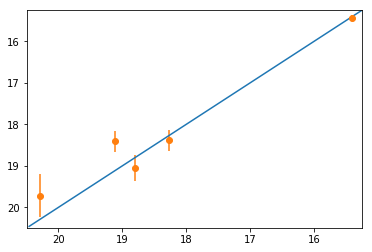

In [2]:
nchoice=5
gain = 1e-10
mag = numpy.random.choice(sample,nchoice)
err= numpy.sqrt(10**(-0.4*mag)/gain)*gain
mag_err=mag+2.5*numpy.log10(10**(-0.4*(mag))+err)
mag_inst = -2.5*numpy.log10(10**(-0.4*mag)+numpy.random.randn(nchoice)*err)
mag_cat = -2.5*numpy.log10(10**(-0.4*mag)+5.*numpy.random.randn(nchoice)*err)
mag, mag_inst

magmax=1.01*max(mag_cat.max(),mag_inst.max())
magmin=0.99*min(mag_cat.min(),mag_inst.min())
x=numpy.arange(magmin,magmax,0.1)
pylab.plot(x,x,"-")
pylab.errorbar(mag_cat,mag_inst,yerr=5*mag_err,fmt="o")
pylab.xlim(magmax,magmin)
pylab.ylim(magmax,magmin)


やっと準備が整った．なんとなくそれっぽく見えるので，これを使って測光原点を決めてみる．
測光原点は 0 のはずで，測光原点のエラーは bootstrap で求める．

Error on zero = 0.172585, Bias on zero = -0.180424


Text(0.5,0,'Magzero Error')

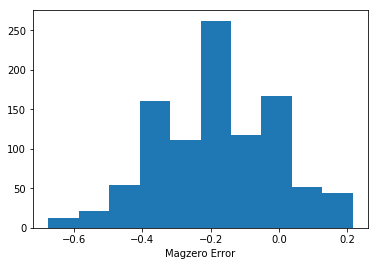

In [3]:
import scipy.optimize
def f(x,b):
    return x+b

barry = []
for i in range(1000):
    idx = numpy.random.choice(range(len(mag_cat)),len(mag_cat))
    b,ber=scipy.optimize.curve_fit(f,mag_cat[idx],mag_inst[idx])
    barry.append(b)
barry = numpy.array(barry)
print "Error on zero = %f, Bias on zero = %f" % (barry.std(ddof=1), barry.mean() )
pylab.hist(barry)
pylab.xlabel("Magzero Error")

異なる realization で測光原点誤差の分布がどうなるかを調べる．

/Users/yutsumi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


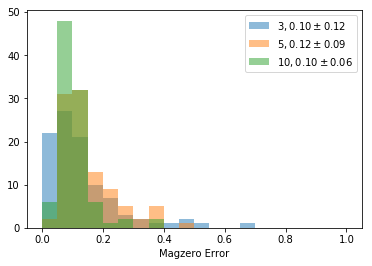

In [4]:
for nchoice in [3,5,10]:
    bstd = []
    bmean = []
    for j in range(100):
        try:
            # draw a number of nchoice of samples, and calculate mag, mag_err, mag_cat, mag_inst ....
            mag = numpy.random.choice(sample,nchoice)
            err= numpy.sqrt(10**(-0.4*mag)/gain)*gain
            mag_err=mag+2.5*numpy.log10(10**(-0.4*(mag))+err)
            mag_inst = -2.5*numpy.log10(10**(-0.4*mag)+numpy.random.randn(nchoice)*err)
            mag_cat = -2.5*numpy.log10(10**(-0.4*mag)+5.*numpy.random.randn(nchoice)*err)

            # do magzero calculation on bootstrap samples assuming linearity is well enough
            barry = []
            for i in range(1000):
                idx = numpy.random.choice(range(len(mag_cat)),len(mag_cat))
                b,ber=scipy.optimize.curve_fit(f,mag_cat[idx],mag_inst[idx])
                barry.append(b)
            barry = numpy.array(barry)
#            print "Error on zero = %f, Bias on zero = %f" % (barry.std(), barry.mean() )
            bstd.append(barry.std(ddof=1))
            bmean.append(barry.mean())
        except:
            pass
    bstd = numpy.array(bstd)
    bmean = numpy.array(bmean)
    pylab.hist(bstd,label=r"$%d, %.2f\pm%.2f$"%(nchoice, numpy.median(bstd),numpy.std(bstd)),
               range=(0,1),bins=20,alpha=0.5)
pylab.xlabel("Magzero Error")
pylab.legend()

1. Bootstrap サンプリングをすれば測光原点のばらつきが求められる．（上図凡例内に記載）

2. 同じサンプルを使っているのでばらつきの真値は同じはずで，およそ 0.1 前後に収束しているように見える．

3. 5点 bootstrap を使っても，例えば一回の realization で 0.17 等級と決まっていて（本当の値は~0.1だけど），これをサンプル数の平方根 ($\sqrt{5}$) で割ると 0.07 等級．決まった測光原点の誤差はこれくらい．